In [1]:
import os 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

from src.utils import *
from src.model import *
from src.dataloader import *
from src.metrics import *

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

def plot_rd(heatmap):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(np.abs(heatmap).sum(-1).sum(-1)) # Range-Doppler
    ax[1].imshow(np.abs(heatmap).sum(0).sum(-1)) # Range-Azimuth
    plt.show()
    plt.close()
    plt.clf()

cuda


In [ ]:
frame_path = "Hupr/Processed/single_1/hori/000000001.npy"
radar_data = SingleFrameFullDataset(frame_path=frame_path)
full_dataloader = DataLoader(radar_data, batch_size=1, shuffle=True)

c:\Users\mahat\anaconda3\envs\llm\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
model = INRNet(
    positional_embedding='ffm', 
    in_features=4, 
    out_features=2, 
    hidden_layers=4, 
    hidden_features=256, 
    nonlinearity='relu', 
    map_size=2048, 
    map_scale=256
)
model = model.to(device)
model.load_state_dict(torch.load('weights/single_frame_inr'))
model.eval()

INRNet(
  (map): FourierFeatMapping()
  (net): INRBlock(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (4): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (5): Sequential(
        (0): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [5]:
with torch.no_grad():
    for i, data in enumerate(full_dataloader):
        coordinates, values, heatmap = data
        heatmap = heatmap[0, ...]
        
        coordinates = coordinates.to(device)
        values = values.to(device)
        heatmap = heatmap.to(device)

        values_pred = model(coordinates)
    
heatmap_pred = torch.reshape(values_pred, shape=[1, 16, 64, 64, 8, 2])
heatmap_pred = heatmap_pred[0, ...]
heatmap_pred = heatmap_pred[..., 0] + 1j * heatmap_pred[..., 1] 
heatmap_pred = heatmap_pred.detach().cpu().numpy()

heatmap = heatmap.detach().cpu().numpy()
print(heatmap.shape, heatmap_pred.shape)
print(heatmap.dtype, heatmap_pred.dtype)

(16, 64, 64, 8) (16, 64, 64, 8)
complex64 complex64


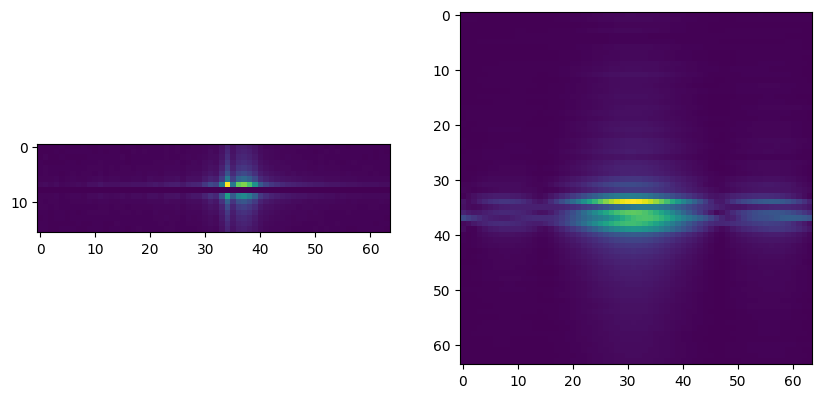

<Figure size 640x480 with 0 Axes>

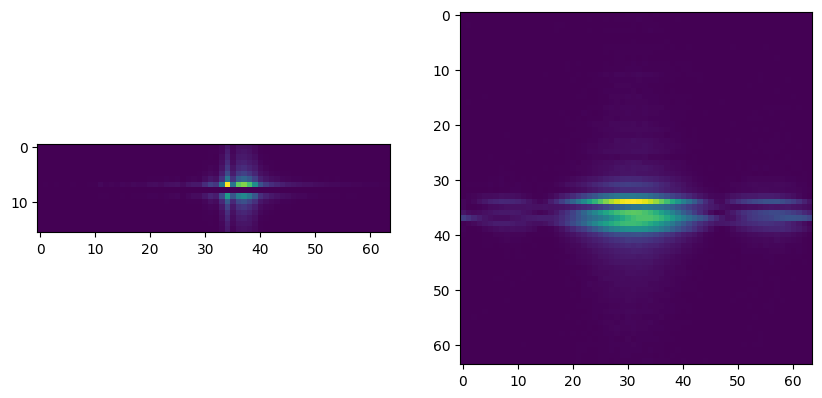

<Figure size 640x480 with 0 Axes>

In [6]:
plot_rd(heatmap)
plot_rd(heatmap_pred)